<a href="https://colab.research.google.com/github/Sundragon1993/TUM_cv3dst/blob/main/faster_rcnn_fpn_training_mot_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster R-CNN with FPN training on MOT17



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive



## Download torchvision and coco

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 6.41 MiB/s, done.
Resolving deltas: 100% (576/576), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/us

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 9575 (delta 3), reused 1 (delta 0), pack-reused 9559
Receiving objects: 100% (9575/9575), 11.40 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (6646/6646), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


### Download MOT 17 Dataset

In [ ]:
%%shell

# download the MOT17 detection challenge
wget https://motchallenge.net/data/MOT17Det.zip .
# extract it in the current folder
unzip MOT17Det.zip

--2020-08-20 17:21:06--  https://motchallenge.net/data/MOT17Det.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1952547113 (1.8G) [application/zip]
Saving to: ‘MOT17Det.zip’

MOT17Det.zip          5%[>                   ] 109.49M  10.5MB/s    eta 3m 22s 

Let's have a look at the dataset and how it is layed down.

The data is structured as follows


In [ ]:
%%shell

ls
ls train
ls test

ls train/MOT17-02/
ls train/MOT17-02/img1/


Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
from PIL import Image
Image.open('train/MOT17-02/img1/000001.jpg')

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import configparser
import csv
import os
import os.path as osp
import pickle

from PIL import Image
import numpy as np
import scipy
import torch


class MOT17ObjDetect(torch.utils.data.Dataset):
    """ Data class for the Multiple Object Tracking Dataset
    """

    def __init__(self, root, transforms=None, vis_threshold=0.25):
        self.root = root
        self.transforms = transforms
        self._vis_threshold = vis_threshold
        self._classes = ('background', 'pedestrian')
        self._img_paths = []

        for f in os.listdir(root):
            path = os.path.join(root, f)
            config_file = os.path.join(path, 'seqinfo.ini')

            assert os.path.exists(config_file), \
                'Path does not exist: {}'.format(config_file)

            config = configparser.ConfigParser()
            config.read(config_file)
            seq_len = int(config['Sequence']['seqLength'])
            im_width = int(config['Sequence']['imWidth'])
            im_height = int(config['Sequence']['imHeight'])
            im_ext = config['Sequence']['imExt']
            im_dir = config['Sequence']['imDir']

            _imDir = os.path.join(path, im_dir)

            for i in range(1, seq_len + 1):
                img_path = os.path.join(_imDir, f"{i:06d}{im_ext}")
                assert os.path.exists(img_path), \
                    'Path does not exist: {img_path}'
                # self._img_paths.append((img_path, im_width, im_height))
                self._img_paths.append(img_path)

    @property
    def num_classes(self):
        return len(self._classes)

    def _get_annotation(self, idx):
        """
        """

        if 'test' in self.root:
          
            num_objs = 0
            boxes = torch.zeros((num_objs, 4), dtype=torch.float32)

            return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': torch.zeros((num_objs), dtype=torch.float32)}
                
        img_path = self._img_paths[idx]
        file_index = int(os.path.basename(img_path).split('.')[0])

        gt_file = os.path.join(os.path.dirname(
            os.path.dirname(img_path)), 'gt', 'gt.txt')

        assert os.path.exists(gt_file), \
            'GT file does not exist: {}'.format(gt_file)

        bounding_boxes = []

        with open(gt_file, "r") as inf:
            reader = csv.reader(inf, delimiter=',')
            for row in reader:
                visibility = float(row[8])
                if int(row[0]) == file_index and int(row[6]) == 1 and int(row[7]) == 1 and visibility >= self._vis_threshold:
                    bb = {}
                    bb['bb_left'] = int(row[2])
                    bb['bb_top'] = int(row[3])
                    bb['bb_width'] = int(row[4])
                    bb['bb_height'] = int(row[5])
                    bb['visibility'] = float(row[8])

                    bounding_boxes.append(bb)

        num_objs = len(bounding_boxes)

        boxes = torch.zeros((num_objs, 4), dtype=torch.float32)
        visibilities = torch.zeros((num_objs), dtype=torch.float32)
        
        for i, bb in enumerate(bounding_boxes):
            # Make pixel indexes 0-based, should already be 0-based (or not)
            x1 = bb['bb_left'] - 1
            y1 = bb['bb_top'] - 1
            # This -1 accounts for the width (width of 1 x1=x2)
            x2 = x1 + bb['bb_width'] - 1
            y2 = y1 + bb['bb_height'] - 1

            boxes[i, 0] = x1
            boxes[i, 1] = y1
            boxes[i, 2] = x2
            boxes[i, 3] = y2
            visibilities[i] = bb['visibility']
            
        return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': visibilities,}

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self._img_paths[idx]
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        target = self._get_annotation(idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self._img_paths)
    
    def write_results_files(self, results, output_dir):
        """Write the detections in the format for MOT17Det sumbission

        all_boxes[image] = N x 5 array of detections in (x1, y1, x2, y2, score)

        Each file contains these lines:
        <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>

        Files to sumbit:
        ./MOT17-01.txt
        ./MOT17-02.txt
        ./MOT17-03.txt
        ./MOT17-04.txt
        ./MOT17-05.txt
        ./MOT17-06.txt
        ./MOT17-07.txt
        ./MOT17-08.txt
        ./MOT17-09.txt
        ./MOT17-10.txt
        ./MOT17-11.txt
        ./MOT17-12.txt
        ./MOT17-13.txt
        ./MOT17-14.txt
        """

        #format_str = "{}, -1, {}, {}, {}, {}, {}, -1, -1, -1"

        files = {}
        for image_id, res in results.items():
            path = self._img_paths[image_id]
            img1, name = osp.split(path)
            # get image number out of name
            frame = int(name.split('.')[0])
            # smth like /train/MOT17-09-FRCNN or /train/MOT17-09
            tmp = osp.dirname(img1)
            # get the folder name of the sequence and split it
            tmp = osp.basename(tmp).split('-')
            # Now get the output name of the file
            out = tmp[0]+'-'+tmp[1]+'.txt'
            outfile = osp.join(output_dir, out)

            # check if out in keys and create empty list if not
            if outfile not in files.keys():
                files[outfile] = []

            for box, score in zip(res['boxes'], res['scores']):
                x1 = box[0].item()
                y1 = box[1].item()
                x2 = box[2].item()
                y2 = box[3].item()
                files[outfile].append(
                    [frame, -1, x1, y1, x2 - x1, y2 - y1, score.item(), -1, -1, -1])

        for k, v in files.items():
            with open(k, "w") as of:
                writer = csv.writer(of, delimiter=',')
                for d in v:
                    writer.writerow(d)

    def print_eval(self, results, ovthresh=0.5):
        """Evaluates the detections (not official!!)

        all_boxes[cls][image] = N x 5 array of detections in (x1, y1, x2, y2, score)
        """

        if 'test' in self.root:
            print('No GT data available for evaluation.')
            return
            
        # Lists for tp and fp in the format tp[cls][image]
        tp = [[] for _ in range(len(self._img_paths))]
        fp = [[] for _ in range(len(self._img_paths))]

        npos = 0
        gt = []
        gt_found = []

        for idx in range(len(self._img_paths)):
            annotation = self._get_annotation(idx)
            bbox = annotation['boxes'][annotation['visibilities'].gt(self._vis_threshold)]
            found = np.zeros(bbox.shape[0])
            gt.append(bbox.cpu().numpy())
            gt_found.append(found)

            npos += found.shape[0]

        # Loop through all images
        # for res in results:
        for im_index, (im_gt, found) in enumerate(zip(gt, gt_found)):
            # Loop through dets an mark TPs and FPs
            
            # im_index = res['image_id'].item()
            # im_det = results['boxes']
            # annotation = self._get_annotation(im_index)
            # im_gt = annotation['boxes'][annotation['visibilities'].gt(0.5)].cpu().numpy()
            # found = np.zeros(im_gt.shape[0])
            
            im_det = results[im_index]['boxes'].cpu().numpy()

            im_tp = np.zeros(len(im_det))
            im_fp = np.zeros(len(im_det))
            for i, d in enumerate(im_det):
                ovmax = -np.inf

                if im_gt.size > 0:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(im_gt[:, 0], d[0])
                    iymin = np.maximum(im_gt[:, 1], d[1])
                    ixmax = np.minimum(im_gt[:, 2], d[2])
                    iymax = np.minimum(im_gt[:, 3], d[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    # union
                    uni = ((d[2] - d[0] + 1.) * (d[3] - d[1] + 1.) +
                            (im_gt[:, 2] - im_gt[:, 0] + 1.) *
                            (im_gt[:, 3] - im_gt[:, 1] + 1.) - inters)

                    overlaps = inters / uni
                    ovmax = np.max(overlaps)
                    jmax = np.argmax(overlaps)

                if ovmax > ovthresh:
                    if found[jmax] == 0:
                        im_tp[i] = 1.
                        found[jmax] = 1.
                    else:
                        im_fp[i] = 1.
                else:
                    im_fp[i] = 1.

            tp[im_index] = im_tp
            fp[im_index] = im_fp

        # Flatten out tp and fp into a numpy array
        i = 0
        for im in tp:
            if type(im) != type([]):
                i += im.shape[0]

        tp_flat = np.zeros(i)
        fp_flat = np.zeros(i)

        i = 0
        for tp_im, fp_im in zip(tp, fp):
            if type(tp_im) != type([]):
                s = tp_im.shape[0]
                tp_flat[i:s+i] = tp_im
                fp_flat[i:s+i] = fp_im
                i += s

        tp = np.cumsum(tp_flat)
        fp = np.cumsum(fp_flat)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth (probably not needed in my code but doesn't harm if left)
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        tmp = np.maximum(tp + fp, np.finfo(np.float64).eps)

        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

        tp, fp, prec, rec, ap = np.max(tp), np.max(fp), prec[-1], np.max(rec), ap
        
        print(f"AP: {ap} Prec: {prec} Rec: {rec} TP: {tp} FP: {fp}")


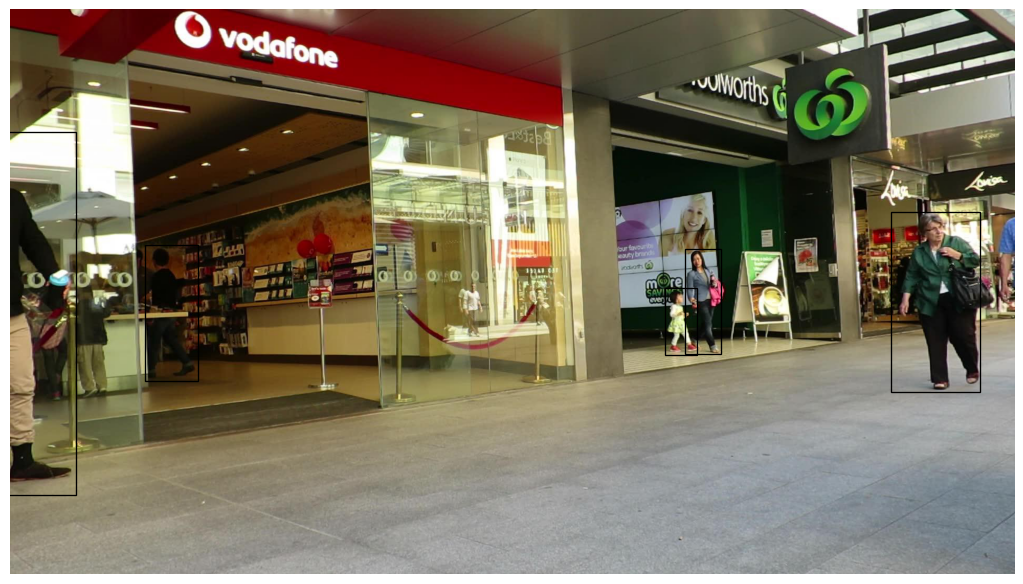

In [ ]:
import matplotlib.pyplot as plt
import transforms as T

dataset = MOT17ObjDetect('train')
img, target = dataset[0]

def plot(img, boxes):
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap='gray')
  fig.set_size_inches(width / 80, height / 80)

  for box in boxes:
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0)
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()

img, target = T.ToTensor()(img, target)
plot(img, target['boxes'])

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    
    return model

DATASETS

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = MOT17ObjDetect('train', get_transform(train=True))
dataset_no_random = MOT17ObjDetect('train', get_transform(train=False))
dataset_test = MOT17ObjDetect('test', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_no_random = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

INIT MODEL AND OPTIM

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_detection_model(dataset.num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


TRAINING

In [ ]:
def evaluate_and_write_result_files(model, data_loader):
  model.eval()
  results = {}
  for imgs, targets in data_loader:
    imgs = [img.to(device) for img in imgs]

    with torch.no_grad():
        preds = model(imgs)
    
    for pred, target in zip(preds, targets):
        results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                              'scores': pred['scores'].cpu()}

  data_loader.dataset.print_eval(results)
  data_loader.dataset.write_results_files(results, 'gdrive/My Drive/Colab Notebooks/faster_rcnn_fpn_training_mot_17/resnet50/')
  
# evaluate_and_write_result_files(model, data_loader_test)
evaluate_and_write_result_files(model, data_loader_no_random)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


AP: 0.8749080657738261 Prec: 0.9220888904528979 Rec: 0.916776488424981 TP: 78609.0 FP: 6642.0


In [ ]:
num_epochs = 27

for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    if epoch % 3 == 0:
      evaluate_and_write_result_files(model, data_loader_no_random)
      torch.save(model.state_dict(), f"gdrive/My Drive/Colab Notebooks/faster_rcnn_fpn_training_mot_17/model_epoch_{epoch}.model")

QUALITATIVE TESTING

In [ ]:
# pick one image from the test set
dataset = MOT17ObjDetect('train', get_transform(train=False))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for imgs, target in data_loader:
    print(dataset._img_paths[0])
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    plot(imgs[0], prediction['boxes'])
    plot(imgs[0], target[0]['boxes'])
    break
